In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import pickle
import sys
sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
from data_preprocessing_helpers import get_lonlatbox
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
from plot_functions import plot_cross_section, draw_color_blocks, add_inset_plot
sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions

import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

In [19]:
## Load Data
lonrange = [135,-165]
latrange = [20,70]


path = '/net/thermo/atmosdyn2/atroman/PACaccu/cdf'

ds_p_all = xr.open_mfdataset(f'{path}/P*')
ds_p_all = ds_p_all.squeeze('lev2')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/model_level_coord/RH_ifs.nc')

## Lonlatbox  -- apply to model-level data
ds_p = get_lonlatbox(ds_p_all, lon_range=lonrange, lat_range=latrange)
ds_p['tsubsi']  = ds_p['tsubs'] + ds_p['tsubi']

ds_p['tmeltsi'] = ds_p['tmelts']+ ds_p['tmelti']
ds_p['SIWC']    = ds_p['SWC']+ ds_p['IWC']
ds_p['RH_ifs']  = da_rh['RH_ifs']
## Subselect dataset around cyclone center
ds_p_subset  = ds_p.isel(time=slice(10, -10)).sel(lon=slice(150,185), lat=slice(30,60) )
ds_p_set  = ds_p.isel(time=slice(0, -1), lon=slice(0,-1), lat=slice(0,-1) )

In [21]:
ds_p_set.RH_ifs

<xarray.DataArray 'RH_ifs' (time: 72, lev: 83, lat: 125, lon: 149)>
[111303000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-04-08T12:00:00 ... 2017-04-11T11:00:00
  * lon      (lon) float64 135.2 135.6 136.0 136.4 ... 193.2 193.6 194.0 194.4
  * lat      (lat) float32 20.0 20.4 20.8 21.2 21.6 ... 68.0 68.4 68.8 69.2 69.6
Dimensions without coordinates: lev

In [22]:
X_train_tmeltsi, X_test_tmeltsi, y_train_tmeltsi, y_test_tmeltsi = rf_functions.get_train_test_split(ds_p=ds_p_set, 
                                                                                                     bcp='tmeltsi', 
                                                                                                     save=False)


Create feature dataframe for tmeltsi

Apply domain filter to tmeltsi (SIWC > 0 & Temp > 0
Drop all points where SIWC == 0 and Temp < 0
Filtered dataframe size:	1.71e+06 	1.5% of size compared to unfiltered. (Points dropped: 109591899)
Class 0 fraction (before drop):	99.6%

Class Balance New Dataframe:
------------------------------
Class 0 fraction:	78.8%		1348263 Points
Class 1 fraction:	18.2%		 311903 Points
Class 2 fraction:	 3.0%		  50935 Points
------------------------------		--------------
Toatal points in new df:		1711101 Points

Scale Temperature values
Applying z-scaling...
          bcp_label          SIWC        RH_ifs          Temp            CC  \
count  1.711101e+06  1.711101e+06  1.711101e+06  1.711101e+06  1.711101e+06   
mean   2.418168e-01  3.306841e-02  7.686019e-01 -9.981746e-07  1.194618e-01   
std    4.938833e-01  7.850512e-02  1.860459e-01  9.994844e-01  2.852667e-01   
min    0.000000e+00  9.313226e-07  2.553484e-03 -1.189605e+00  0.000000e+00   
25%    0.00000

---

### TmeltSI - model

In [5]:
def find_best_parameters_tmeltsi(X_train, y_train):
    class_weights = [{0: 1, 1: x, 2:y} for x in [2,3] for y in [4,5]]
    max_depths = [9]
    trees = [600]
    
    best_params = None
    best_score = -1
    best_rf_classifier = None

    # Create a custom scorer using F1 score
    f1_scorer = make_scorer(f1_score, average='macro')

    # Iterate over the parameter grid and train the models sequentially
    for class_weight in class_weights:
        for max_depth in max_depths:
            for n_trees in trees:
                print(f"Training with class_weight={class_weight}, max_depth={max_depth}, and n_trees={n_trees}")

                rf_classifier = RandomForestClassifier(n_estimators=n_trees,
                                                       criterion='gini',
                                                       max_depth=max_depth,
                                                       max_features='sqrt',
                                                       oob_score=True,
                                                       verbose=0,
                                                       n_jobs=-2,
                                                       class_weight=class_weight,
                                                       random_state=42)

                # Perform cross-validation and calculate the mean F1 score
                scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring=f1_scorer)
                mean_score = np.mean(scores)

                # Update the best parameters and score if necessary
                if mean_score > best_score:
                    best_params = {'class_weight': class_weight, 'max_depth': max_depth, 'n_trees': n_trees}
                    best_score = mean_score
                    best_rf_classifier = rf_classifier

                print(f"Mean F1 score: {mean_score}")

    # Print the best parameters and score
    print("Best parameters: ", best_params)
    print("Best score: ", best_score)

    # Fit the best model to the entire training data
    best_rf_classifier.fit(X_train, y_train)

    # Return the best estimator
    return best_rf_classifier

In [6]:
#best_rf_classifier_tmeltsi = find_best_parameters_tmeltsi(X_train_tmeltsi, y_train_tmeltsi)

============================  Test  ============================
Confusion matrix:
[[249277  19883    647]
 [  5569  53226   3436]
 [    33   2318   7832]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95    269807
         1.0       0.71      0.86      0.77     62231
         2.0       0.66      0.77      0.71     10183

    accuracy                           0.91    342221
   macro avg       0.78      0.85      0.81    342221
weighted avg       0.92      0.91      0.91    342221



<AxesSubplot:>

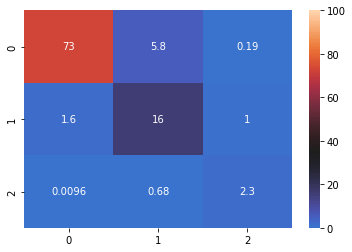

In [23]:
##################
## Tmeltsi model #
##################

class_weights = {0:1, 1:3, 2:6}
# Train forest for the tsubsi
rf_classifier_tmeltsi = RandomForestClassifier(n_estimators=600,
                                               criterion='gini', 
                                               max_depth=10,
                                               max_features= 'sqrt',                         # 'sqrt',          # The number of features to consider when looking for the best split
                                               oob_score=True,
                                               verbose=0,
                                               n_jobs=-1,
                                               class_weight= class_weights,                #class_weights,   #balanced , “balanced_subsample”,
                                               random_state=42)
# Fit Forest
rf_classifier_tmeltsi.fit(X_train_tmeltsi, y_train_tmeltsi)

# Predict and evaluate the model for the tsubsi process
y_pred_model_tmeltsi = rf_classifier_tmeltsi.predict(X_test_tmeltsi)
cm_tmeltsi = rf_functions.get_confmat_clasreport(y_test_tmeltsi, y_pred_model_tmeltsi, model='Test')

sns.heatmap(cm_tmeltsi*100/np.sum(cm_tmeltsi), annot=True, center=35,vmax=100,vmin=0)

In [24]:
feature_list = ['SIWC', 'RH_ifs', 'Temp', 'CC', 'W']

# Get numerical feature importances
importances = list(rf_classifier_tmeltsi.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: RH_ifs               Importance: 0.35
Variable: Temp                 Importance: 0.34
Variable: SIWC                 Importance: 0.2
Variable: CC                   Importance: 0.07
Variable: W                    Importance: 0.04


[None, None, None, None, None]

In [25]:
## Save random forest classifier
path = '/home/freimax/msc_thesis/scripts/random_forest/models'
with open(f'{path}/rf_classifier_tmeltsi.pickle', 'wb') as f:
    pickle.dump(rf_classifier_tmeltsi, f)

---
---
## Apply random forest on different timesteps

In [26]:
ds_p_all = xr.open_mfdataset('/net/thermo/atmosdyn2/atroman/PACaccu/cdf/P*')
ds_p_all = ds_p_all.squeeze('lev2')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/model_level_coord/RH_ifs.nc')

lonrange = [135,-165]
latrange = [20,70]
ds_p = get_lonlatbox(ds_p_all, lon_range=lonrange, lat_range=latrange)

ds_p['tsubsi']  = ds_p['tsubs'] + ds_p['tsubi']
ds_p['tmeltsi'] = ds_p['tmelts']+ ds_p['tmelti']
ds_p['SIWC']    = ds_p['SWC']+ ds_p['IWC']

In [27]:
### Select time frame for verification
ds_p_t1 = ds_p.isel(time=slice(50,55))
da_rh_t1 = da_rh.isel(time=slice(50,55))
ds_p_t1['RH_ifs'] = da_rh_t1['RH_ifs']

In [28]:

## Choose Model
model = rf_classifier_tmeltsi


#-------------------------------------------------------------
# Get ground-truth, predcitons and baseline for new timeframe
#-------------------------------------------------------------

## Get a data-array with the predicitons
print('Make random forest predictions')
da_y_pred_tmeltsi = rf_functions.predict_bcp_labels(ds_p_t1, model,  water_type='SIWC', type_filteredvalues='zero', add_temp_filter=True)
da_y_pred_tmeltsi_binary = da_y_pred_tmeltsi.where(da_y_pred_tmeltsi != 2, 1) 
np_y_pred_tmeltsi = da_y_pred_tmeltsi.values.flatten()
np_y_pred_tmeltsi_binary = da_y_pred_tmeltsi_binary.values.flatten()

Make random forest predictions

Predict labels using random forest
-------------------------------------------------------------------------------------------------------------
Create df_features
Apply domain-filters to df_features:
Drop all points where SIWC == 0 and Temp < 0

Scale Temperature values
Applying z-scaling...
               SIWC         RH_ifs          Temp             CC              W
count  1.256550e+05  125655.000000  1.256550e+05  125655.000000  125655.000000
mean   4.434042e-02       0.768620 -9.928273e-08       0.113270      -0.034528
std    1.054678e-01       0.186240  9.999958e-01       0.275829       0.244184
min    9.313226e-07       0.003887 -1.171318e+00       0.000000      -4.570383
25%    3.967434e-04       0.669708 -7.253078e-01       0.000000      -0.080401
50%    2.494082e-03       0.807036 -2.423710e-01       0.000000      -0.005765
75%    2.503861e-02       0.910564  4.188343e-01       0.023438       0.058228
max    2.357095e+00       1.074240  1.0049

In [29]:

## Get the Ground-truth values
print('Get the true labels for the bcp-processes')
da_y_true_tmeltsi = rf_functions.get_y_true(data_array=ds_p_t1.tmeltsi, thresholds={'weak':-0.075,'medium':-0.75})
np_y_true_tmeltsi = da_y_true_tmeltsi.values.flatten()
da_y_true_tmeltsi_binary = da_y_true_tmeltsi.where(da_y_true_tmeltsi != 2, 1) 
np_y_true_tmeltsi_binary  = da_y_true_tmeltsi_binary.values.flatten()


## Get the Baseline predictions
print('Get the baseline labels for the bcp-processes')
da_y_baseline_tmeltsi = rf_functions.get_y_baseline(input_data=ds_p_t1, bcp='tmeltsi', thr_vars=['SIWC','T'], thr_metrics = '50%')
np_y_baseline_tmeltsi = da_y_baseline_tmeltsi.values.flatten()


Get the true labels for the bcp-processes
Get the baseline labels for the bcp-processes


In [30]:
cm_rf=rf_functions.get_confmat_clasreport(np_y_true_tmeltsi_binary, np_y_pred_tmeltsi_binary, model='RandomForest')
cm_bl=rf_functions.get_confmat_clasreport(np_y_true_tmeltsi_binary, np_y_baseline_tmeltsi   , model='Baseline')


============================  RandomForest  ============================
Confusion matrix:
[[7803257    5549]
 [   9009   25685]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   7808806
         1.0       0.82      0.74      0.78     34694

    accuracy                           1.00   7843500
   macro avg       0.91      0.87      0.89   7843500
weighted avg       1.00      1.00      1.00   7843500

============================  Baseline  ============================
Confusion matrix:
[[7788147   20659]
 [  29609    5085]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   7808806
         1.0       0.20      0.15      0.17     34694

    accuracy                           0.99   7843500
   macro avg       0.60    

In [31]:
## Print classification report only for RF-model (with 3 classes)
a=rf_functions.get_confmat_clasreport(np_y_true_tmeltsi, np_y_pred_tmeltsi, model='RandomForest')

============================  RandomForest  ============================
Confusion matrix:
[[7803257    5381     168]
 [   8298   19399    1216]
 [    711    1412    3658]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   7808806
         1.0       0.74      0.67      0.70     28913
         2.0       0.73      0.63      0.68      5781

    accuracy                           1.00   7843500
   macro avg       0.82      0.77      0.79   7843500
weighted avg       1.00      1.00      1.00   7843500



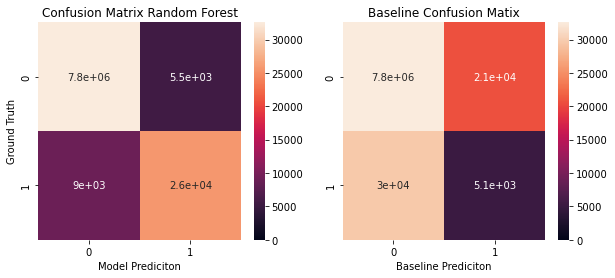

In [32]:
vmax_rf = np.partition(cm_rf.flatten(), -2)[-2]
vmax_bl = np.partition(cm_bl.flatten(), -2)[-2]
vmax = max(vmax_bl,vmax_rf) + 0.1*max(vmax_bl,vmax_rf)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.heatmap(cm_rf, annot=True, vmin=0, vmax=vmax, ax=ax1)
sns.heatmap(cm_bl, annot=True, vmin=0, vmax=vmax, ax=ax2)

ax1.set_title(f'Confusion Matrix Random Forest')
ax1.set_ylabel('Ground Truth')
ax1.set_xlabel('Model Prediciton')
ax2.set_xlabel('Baseline Prediciton')
ax2.set_title(f"Baseline Confusion Matix")
# Save the figure
path = '/home/freimax/msc_thesis/figures/case_study_RA19/RF_classification/tmeltsi'
plt.savefig(f'{path}/confusion_matrix.png', dpi=150)

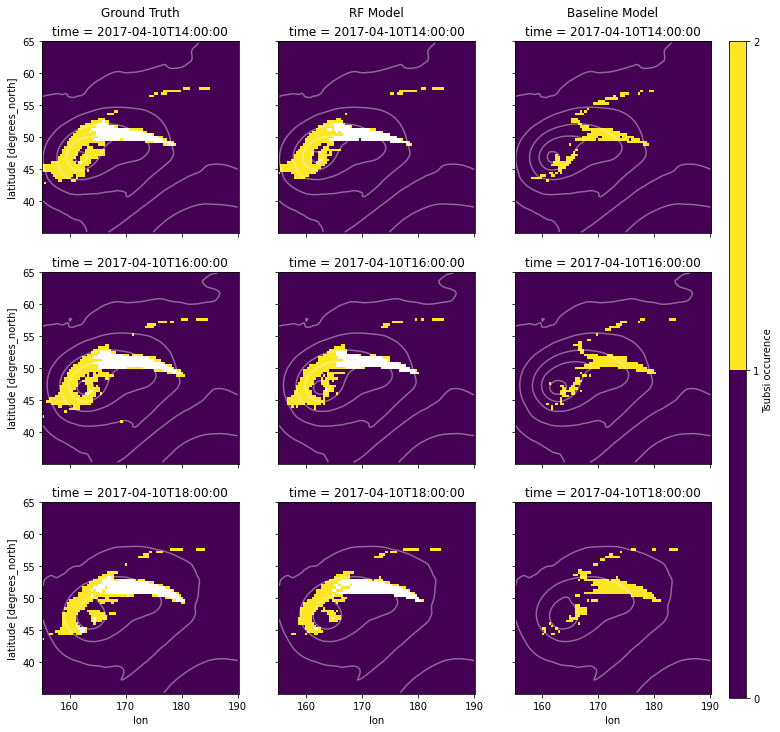

In [33]:
level = 0
#level = 'sum'

lon_min = 155
lon_max = 190

lat_min = 35
lat_max = 65 
#--------------------------------------------------------------------------------
if level == 'sum':
    y_abstruth = da_y_true_tmeltsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    y_baseline = da_y_baseline_tmeltsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    y_rf_model = da_y_pred_tmeltsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    da_slp     = ds_p_t1.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
elif isinstance(level, int) :
    y_abstruth = da_y_true_tmeltsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    y_baseline = da_y_baseline_tmeltsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    y_rf_model = da_y_pred_tmeltsi.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    da_slp     = ds_p_t1.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# Get the middle timestep
middle_timestep = da_y_true_tmeltsi.time.size // 2
# Extract and slice the DataArrays for each timestep
timesteps = [0, middle_timestep, -1]

data_arrays = [
    [y_abstruth.isel(time=t) for t in timesteps],
    [y_rf_model.isel(time=t) for t in timesteps], 
    [y_baseline.isel(time=t) for t in timesteps], 
               ]
slp_array=[da_slp.SLP.isel(time=t) for t in timesteps]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True, sharey=True)
titles = ['Ground Truth', 'RF Model', 'Baseline Model', ]
for col, data_row in enumerate(data_arrays):
    for row, data in enumerate(data_row):
        ax = axes[row][col]
        # Plot the data
        if level == 'sum':
            im = data.plot.imshow(ax=ax, add_colorbar=False, add_labels=True)
        else:
            im = data.plot.imshow(ax=ax, add_colorbar=False, add_labels=True, levels=[0,1,2 ])
        slp_array[row].plot.contour(ax=ax, colors='white', alpha=0.4)
        # Remove labels from the internal axes
        if col != 0:
            ax.set_ylabel('')
        if row != (axes.shape[0]-1):
            ax.set_xlabel('')

for idx, title in enumerate(titles):
    axes[0][idx].text(0.5, 1.15, title, transform=axes[0][idx].transAxes, ha='center', va='center', fontsize=12)


# Add a shared colorbar
cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
cb = plt.colorbar(im, cax=cax)
cb.set_label('Tsubsi occurence')


mid_time = da_y_true_tmeltsi.isel(time=middle_timestep).time
formatted_date = pd.to_datetime(mid_time.values).strftime('%Y-%m-%d')
time2 = da_y_true_tmeltsi.isel(time=0).time.values

time_diff = pd.to_timedelta(mid_time.values - time2)
time_diff_in_hours = time_diff.total_seconds() / 3600
path = '/home/freimax/msc_thesis/figures/case_study_RA19/RF_classification/tmeltsi'
plt.savefig(f'{path}/verification_around_t{formatted_date}_dt{time_diff_in_hours}h_at_lev{level}.png', dpi=250)
plt.show()